In [36]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
IMG_HEIGHT, IMG_WIDTH = 48, 48
batch_size = 32
learning_rate = 0.001
epochs = 50


In [30]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [31]:
train_dataset = datasets.ImageFolder('C:/Users/Asus/PycharmProjects/JupyterProject/fer2013/train', transform=transform)
validation_dataset = datasets.ImageFolder('C:/Users/Asus/PycharmProjects/JupyterProject/fer2013/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

In [32]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.2)
        self.flatten = nn.Flatten()

        # Adjusted based on the size of the input image after convolutional layers
        self.fc1 = nn.Linear(256 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 7)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Output: (32, 48, 48) -> (32, 24, 24)
        x = self.pool(torch.relu(self.conv2(x)))  # Output: (64, 24, 24) -> (64, 12, 12)
        x = self.dropout(x)
        x = self.pool(torch.relu(self.conv3(x)))  # Output: (128, 12, 12) -> (128, 6, 6)
        x = self.dropout(x)
        x = self.pool(torch.relu(self.conv4(x)))  # Output: (256, 6, 6) -> (256, 3, 3)
        x = self.dropout(x)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN().to(device)

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
label_mapping = train_dataset.classes
print('Label Index Mapping:', label_mapping)

In [34]:
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}')

torch.save(model.state_dict(), 'emotion_detection_model.pth')


Epoch [1/50], Loss: 1.6513
Epoch [2/50], Loss: 1.3936
Epoch [3/50], Loss: 1.2790
Epoch [4/50], Loss: 1.2051
Epoch [5/50], Loss: 1.1507
Epoch [6/50], Loss: 1.1099
Epoch [7/50], Loss: 1.0685
Epoch [8/50], Loss: 1.0305
Epoch [9/50], Loss: 0.9952
Epoch [10/50], Loss: 0.9576
Epoch [11/50], Loss: 0.9235
Epoch [12/50], Loss: 0.8964
Epoch [13/50], Loss: 0.8705
Epoch [14/50], Loss: 0.8407
Epoch [15/50], Loss: 0.8103
Epoch [16/50], Loss: 0.7862
Epoch [17/50], Loss: 0.7564
Epoch [18/50], Loss: 0.7401
Epoch [19/50], Loss: 0.7187
Epoch [20/50], Loss: 0.7006
Epoch [21/50], Loss: 0.6744
Epoch [22/50], Loss: 0.6525
Epoch [23/50], Loss: 0.6436
Epoch [24/50], Loss: 0.6212
Epoch [25/50], Loss: 0.6229
Epoch [26/50], Loss: 0.5841
Epoch [27/50], Loss: 0.5772
Epoch [28/50], Loss: 0.5677
Epoch [29/50], Loss: 0.5457
Epoch [30/50], Loss: 0.5316
Epoch [31/50], Loss: 0.5290
Epoch [32/50], Loss: 0.5143
Epoch [33/50], Loss: 0.5057
Epoch [34/50], Loss: 0.4989
Epoch [35/50], Loss: 0.4854
Epoch [36/50], Loss: 0.4801
E

In [37]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in validation_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=label_mapping)
print('Classification Report:\n', report)


Validation Accuracy: 59.92%
Classification Report:
               precision    recall  f1-score   support

       angry       0.48      0.51      0.49       958
     disgust       0.77      0.61      0.68       111
        fear       0.48      0.42      0.45      1024
       happy       0.80      0.80      0.80      1774
     neutral       0.53      0.52      0.52      1233
         sad       0.47      0.51      0.49      1247
    surprise       0.75      0.75      0.75       831

    accuracy                           0.60      7178
   macro avg       0.61      0.59      0.60      7178
weighted avg       0.60      0.60      0.60      7178



Accuracy: 59.92%


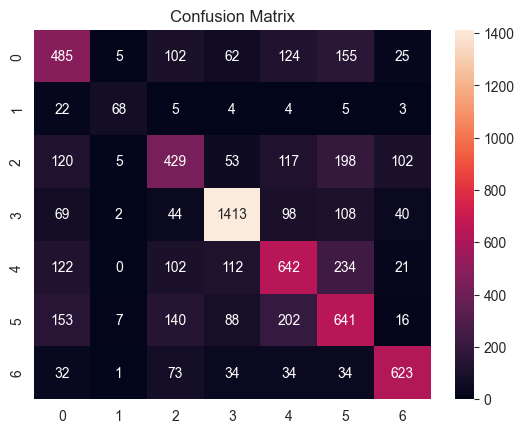

In [38]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in validation_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

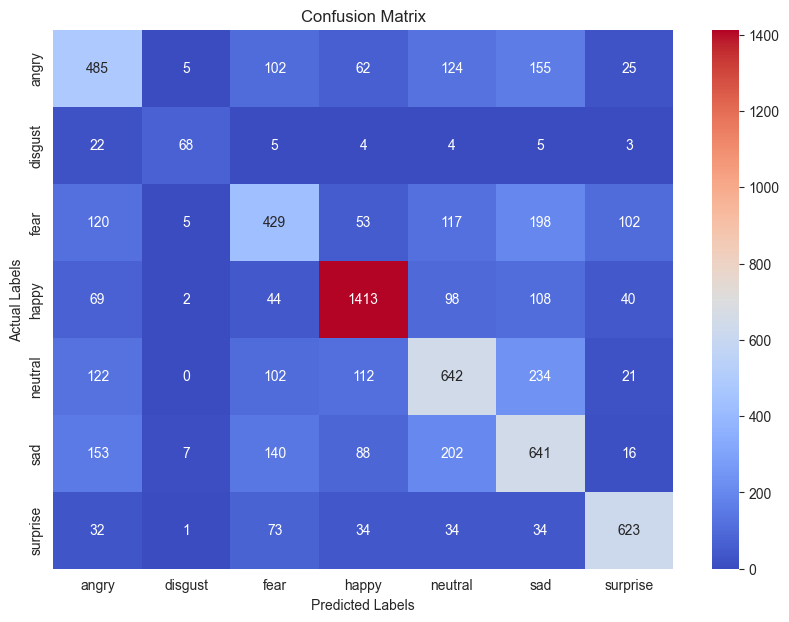

In [39]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=label_mapping, yticklabels=label_mapping)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()
